In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

In [2]:
df = []
for fname in glob.glob("csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
    report_date = fname.split("/")[-1].replace(".csv", "")
    _df = pd.read_csv(fname)
    _df["report_date"] = report_date
    df.append(_df[_df["Country/Region"] == "Germany"])
df = pd.concat(df)
df["Last Update"] = pd.to_datetime(df["Last Update"])
df["report_date"] = pd.to_datetime(df["report_date"])
df["date"] = df["report_date"] # seems to make more sense than the "Last Update"
df = df.sort_values(by="date")
df = df.drop_duplicates()
#df = df.iloc[:-5]

In [3]:
df.tail()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,report_date,Latitude,Longitude,date
8,NaN,Germany,2020-03-09 18:13:11,1176.0,2.0,18.0,2020-03-09,51.0000,9.0000,2020-03-09
6,NaN,Germany,2020-03-10 18:53:02,1457.0,2.0,18.0,2020-03-10,51.0000,9.0000,2020-03-10
6,NaN,Germany,2020-03-11 19:13:17,1908.0,3.0,25.0,2020-03-11,51.0000,9.0000,2020-03-11
6,NaN,Germany,2020-03-12 09:53:06,2078.0,3.0,25.0,2020-03-12,51.0000,9.0000,2020-03-12
53,NaN,Germany,2020-03-11 20:00:00,3675.0,7.0,46.0,2020-03-13,51.1657,10.4515,2020-03-13


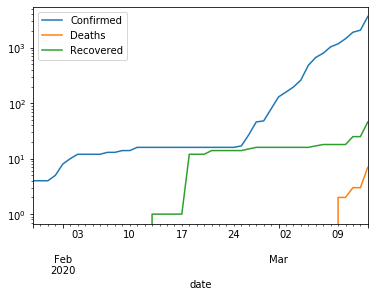

In [4]:
fig, ax = plt.subplots()
df.plot(x="date", y="Confirmed", ax=ax)
df.plot(x="date", y="Deaths", ax=ax)
df.plot(x="date", y="Recovered", ax=ax)
ax.set_yscale("log")

In [5]:
def func(x, a, b, c):
    return a * np.exp(b * (x - c))

In [6]:
x_int = df["date"].astype("int").values
x_int = (x_int - x_int[0]) / 1e9 / 3600 / 24
x = x_int[1:]
y = np.diff(df["Confirmed"]) / np.diff(x_int)
y_int = df["Confirmed"].values

In [7]:
popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=(1, len(x) / (x[-1] - x[0]), x[0]))

(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.]),
 <a list of 7 Text xticklabel objects>)

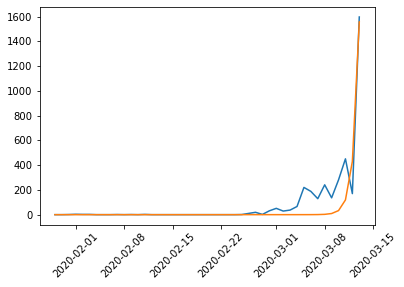

In [8]:
plt.plot(df["date"][1:], y)
plt.plot(df["date"][1:], func(x, *popt))
plt.xticks(rotation=45)

In [9]:
popt_int, pcov_int = scipy.optimize.curve_fit(func, x_int, y_int, p0=(1, len(x) / (x[-1] - x[0]), x[0]))

In [10]:
popt_int

array([0.02397463, 0.26555196, 0.39434565])

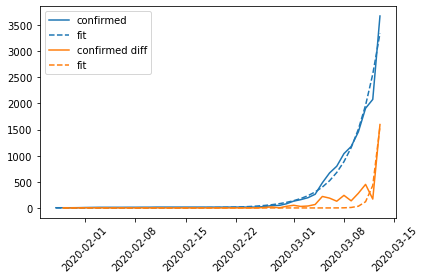

In [11]:
fig, ax = plt.subplots()

ax.plot(df["date"], y_int, label="confirmed", color="C0")
ax.plot(df["date"], func(x_int, *popt_int), "--", label="fit", color="C0")

ax.plot(df["date"][1:], y, label="confirmed diff", color="C1")
ax.plot(df["date"][1:], func(x, *popt), "--", label="fit", color="C1")

ax.xaxis.set_tick_params(rotation=45)
ax.legend()

ax.set_yscale("log")
ax.set_ylim(bottom=1e-1)
fig.tight_layout()
fig.savefig("corona_de_log.pdf")
ax.set_ylim(auto=True)
ax.set_yscale("linear")
fig.savefig("corona_de.pdf")

305206.243299807

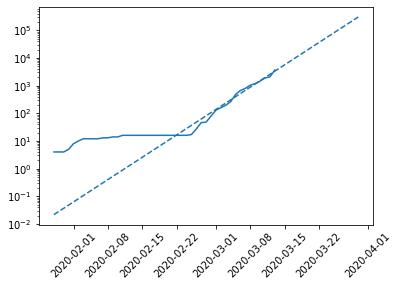

In [21]:
dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-03-30", freq="d")
days = np.arange(len(dates_extrap))
pred = func(days, *popt_int)
fig, ax = plt.subplots()
ax.plot(df["date"], y_int, label="confirmed", color="C0")
ax.plot(dates_extrap, pred, "--", color="C0")
ax.set_yscale("log")
ax.xaxis.set_tick_params(rotation=45)
pred[-1]

In [13]:
dates_extrap[(func(days, *popt_int) > 80e6)][0]

Timestamp('2020-04-20 00:00:00', freq='D')

In [14]:
popt

array([5.12314791e-22, 1.28623660e+00, 1.17170194e+00])

In [15]:
popt_int

array([0.02397463, 0.26555196, 0.39434565])

In [16]:
np.log(2) / popt_int[1]

2.6102129983331976

In [17]:
df["death_rate"] = df["Deaths"] / df["Confirmed"]

In [18]:
df.death_rate.tail()

8     0.001701
6     0.001373
6     0.001572
6     0.001444
53    0.001905
Name: death_rate, dtype: float64